<a href="https://colab.research.google.com/github/alexarlenn/fret-calculation/blob/main/fret_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание прототипа UI веб-приложения
Явление FRET заключается в передаче энергии от донора к акцептору в случае, когда они находятся на близком друг от друга расстоянии и длина волны испускания донора соответствует длине волны возбуждения акцептора.

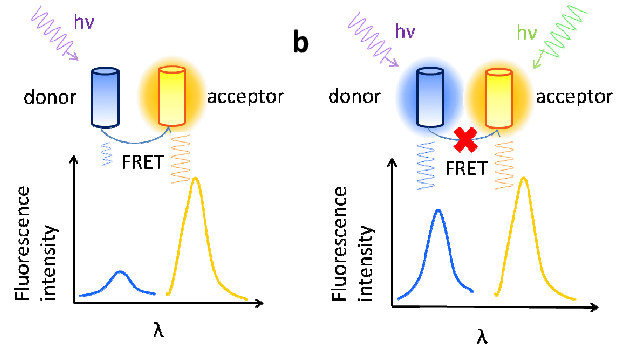

## FRET по определению
$E=\frac{F_a}{F_a + F_d}$


## Однако, микроскоп снимает не F - флуоресценцию, а интенсивность сигнала
$I_d = F_d + B_d +\alpha_{ad}(F_a)$

$I_a = F_a + B_a$

$\alpha_{ad} = 0.21$ - доля перекрывания спектральных каналов донора и акцептора

$B_d$ =1.2 - фоновый сигнал в канале донора

$ B_a$ =0.9 - фоновый сигнал в канале акцептора

## Напишем прототип веб-приложения с графическим интерфейсом и следующими задачами:
* Взять текстовый файл с логами микроскопа (пример: `prox-pure.txt`)
* Прочесть колонки со временем
* Прочесть колонку с интенсивностью донора (Cy3) - 4 колонка
* Прочесть колонку с интенсивностью акцептора (Cy5) - 2 колонка
* Проверить соответствие времен в колонках и отбросить битые данные
* Расчитать гистограмму значений FRET с применением формул выше и возможностью откидывать события ниже, чем пороговое значение по сигналу донора и акцептора, то есть __только для тех случаев где $F_d > 10$ либо $F_a > 5$__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
from ipywidgets import Layout, Label

In [2]:
BackD = 1.3
BackA = 0.9
alpha_ad = 0.21
TrshA = 5
TrshD = 10

In [3]:
def FRET(file, BackD, BackA, alpha_ad, TrshA, TrshD):
    # проверяем, загружен ли файл
    if not file:
        print("Файл не загружен")
        return

    # обрабатываем разные форматы входных данных
    if isinstance(file, tuple) and len(file) > 0:
        # когда manual=True, file приходит как кортеж
        uploaded_file = file[0]
    elif hasattr(file, 'values'):
        # когда manual=False, file приходит как словарь
        uploaded_file = list(file.values())[0]
    else:
        print("Неизвестный формат данных файла")
        return

    # получаем содержимое загруженного файла
    content = uploaded_file['content']

    # чтение файла из байтов
    data = pd.read_csv(io.BytesIO(content), delimiter='\t', skiprows=1)
    data.columns = ['Time1', 'Cy5', 'Time2', 'Cy3']
    data = data.dropna()

    # преобразование типов столбцов с временем и интенсивностью
    data = data.astype(float)

    # проверка на соответствие времени и отбрасывание битых данных
    valid_data = data['Time1'].equals(data['Time2'])
    if valid_data == True:
        print('Корректные данные: Времена сьемки совпадают')
    else:
        print('ВНИМАНИЕ: не совпадают интервалы съемки флуоресценции донора и акцептора')

    BackD = float(BackD)
    BackA = float(BackA)
    alpha_ad = float(alpha_ad)
    TrshA = float(TrshA)
    TrshD = float(TrshD)

    # находим флюоресценцию донора и акцептора
    data['Fa'] = data['Cy5'] - BackA
    data['Fd'] = data['Cy3'] - BackD - alpha_ad * data['Fa']
    # отбрасываем пустые значения
    data = data.loc[((data['Fd'] > 0) & (data['Fa'] > 0))]

    # условия фильтрации для сигналов донора и акцептора
    filtered_data = data.loc[((data['Fd'] > TrshD) | (data['Fa'] > TrshA))].copy()

    # считаем FRET
    filtered_data['FRET'] = filtered_data['Fa'] / (filtered_data['Fa'] + filtered_data['Fd'])

    # cоздаем график
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data['FRET'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('FRET Efficiency')
    plt.ylabel('Frequency')
    plt.title('FRET Efficiency Distribution')
    plt.grid(True, alpha=0.03)
    plt.show()
    return filtered_data

# Создаем виджеты вручную без использования interactive
uploader = widgets.FileUpload(accept='.txt', multiple=False, layout={'width': '200px'})

# Создаем текстовые поля с более широкими описаниями
BackD_w = widgets.FloatText(value=1.3, description='Фон донора:', style={'description_width': '120px'}, layout={'width': '200px'})
BackA_w = widgets.FloatText(value=0.9, description='Фон акцептора:', style={'description_width': '120px'}, layout={'width': '200px'})
TrshD_w = widgets.FloatText(value=10, description='Порог донора:', style={'description_width': '120px'}, layout={'width': '200px'})
TrshA_w = widgets.FloatText(value=5, description='Порог акцептора:', style={'description_width': '120px'}, layout={'width': '200px'})
crosst_w = widgets.FloatText(value=0.21, description='Коэффициент α:', style={'description_width': '120px'}, layout={'width': '200px'})

# Создаем кнопку
calculate_btn = widgets.Button(description="Рассчитать FRET", button_style='success', layout={'width': '200px'})

# Создаем область для вывода
output = widgets.Output()

# Функция-обработчик для кнопки
def on_calculate_clicked(b):
    with output:
        output.clear_output()
        FRET(uploader.value, BackD_w.value, BackA_w.value, crosst_w.value, TrshA_w.value, TrshD_w.value)

# Привязываем функцию к кнопке
calculate_btn.on_click(on_calculate_clicked)

# Создаем простой layout без сложных контейнеров
print("Загрузите файл данных и настройте параметры:\n")

# Первая строка - загрузка файла
file_label = widgets.Label("", layout={'width': '150px', 'margin': '0 0 0 53px'})
file_box = widgets.HBox([file_label, uploader])
display(file_box)

# Вторая строка - параметры фона
background_box = widgets.HBox([BackD_w, BackA_w])
display(background_box)

# Третья строка - параметры порога
threshold_box = widgets.HBox([TrshD_w, TrshA_w])
display(threshold_box)

# Четвертая строка - коэффициент и кнопка
bottom_box = widgets.HBox([crosst_w, calculate_btn])
display(bottom_box)

# Область для вывода
display(output)

Загрузите файл данных и настройте параметры:



Output()